In [2]:
import pandas as pd
import numpy as np
import joblib
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier,StackingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score,KFold,RandomizedSearchCV
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593994 entries, 0 to 593993
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    593994 non-null  int64  
 1   annual_income         593994 non-null  float64
 2   debt_to_income_ratio  593994 non-null  float64
 3   credit_score          593994 non-null  int64  
 4   loan_amount           593994 non-null  float64
 5   interest_rate         593994 non-null  float64
 6   gender                593994 non-null  object 
 7   marital_status        593994 non-null  object 
 8   education_level       593994 non-null  object 
 9   employment_status     593994 non-null  object 
 10  loan_purpose          593994 non-null  object 
 11  grade_subgrade        593994 non-null  object 
 12  loan_paid_back        593994 non-null  float64
dtypes: float64(5), int64(2), object(6)
memory usage: 58.9+ MB


In [5]:
train.head()

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


In [6]:
X_train = train.drop(columns=['id', 'loan_paid_back'])
y_train = train['loan_paid_back']
X_test = test.drop(columns=['id'])
test_ids = test['id']

#EDA BEGINS FROM HERE

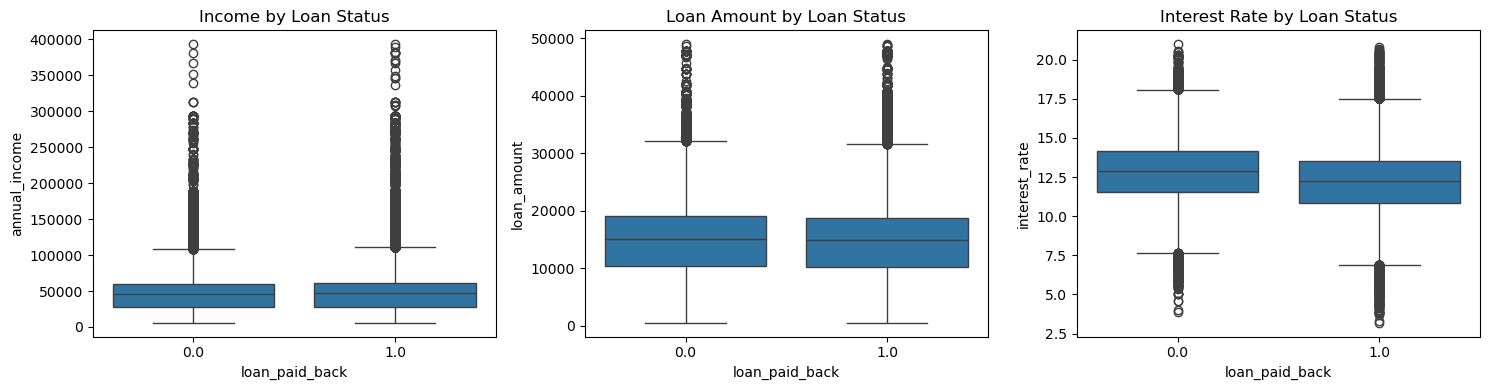

In [7]:
# Quick check: Do these features separate paid vs not-paid?
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

sns.boxplot(data=train, x='loan_paid_back', y='annual_income', ax=axes[0])
axes[0].set_title('Income by Loan Status')

sns.boxplot(data=train, x='loan_paid_back', y='loan_amount', ax=axes[1])
axes[1].set_title('Loan Amount by Loan Status')

sns.boxplot(data=train, x='loan_paid_back', y='interest_rate', ax=axes[2])
axes[2].set_title('Interest Rate by Loan Status')

plt.tight_layout()
plt.show()

In [8]:
train_temp = train.copy()
train_temp['loan_to_income'] = train['loan_amount'] / (train['annual_income'] + 1)
train_temp['payment_estimate'] = train['loan_amount'] * train['interest_rate'] / 100

corr_with_target = train_temp[['annual_income', 'loan_amount', 'interest_rate', 
                                'loan_to_income', 'payment_estimate', 
                                'loan_paid_back']].corr()['loan_paid_back'].sort_values(ascending=False)
print(corr_with_target)

loan_paid_back      1.000000
annual_income       0.006326
loan_amount        -0.003762
loan_to_income     -0.005611
payment_estimate   -0.046777
interest_rate      -0.131184
Name: loan_paid_back, dtype: float64


In [9]:
X_train['interest_burden'] = (X_train['loan_amount'] * X_train['interest_rate']) / (X_train['annual_income'] + 1)
X_test['interest_burden'] = (X_test['loan_amount'] * X_test['interest_rate']) / (X_test['annual_income'] + 1)

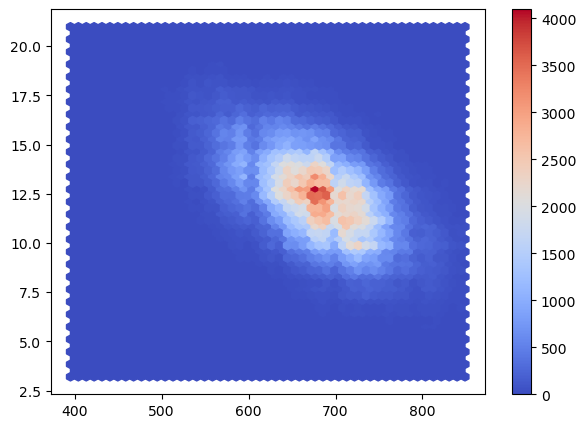

In [10]:
plt.figure(figsize=(7,5))
plt.hexbin(train['credit_score'], train['interest_rate'], gridsize=50, cmap='coolwarm')
plt.colorbar()
plt.show()

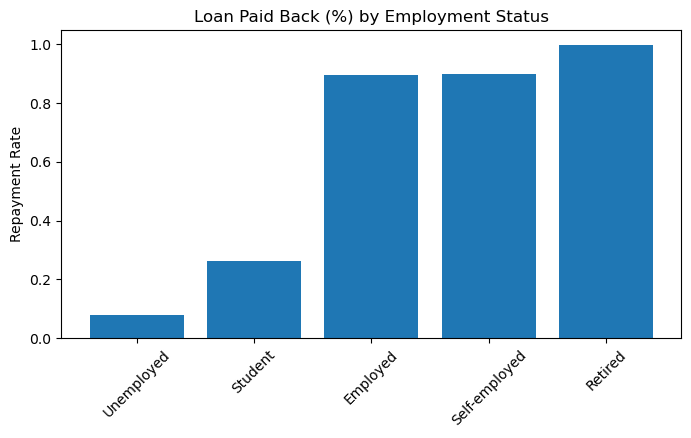

In [11]:
rate = train.groupby('employment_status')['loan_paid_back'].mean().sort_values()

plt.figure(figsize=(8,4))
plt.bar(rate.index, rate.values)
plt.xticks(rotation=45)
plt.ylabel("Repayment Rate")
plt.title("Loan Paid Back (%) by Employment Status")
plt.show()

In [12]:
mapping = {
    "Unemployed": 0,
    "Student": 1,
    "Employed": 3,
    "Self-employed": 3,
    "Retired": 4
}

X_train['employment_status_ord'] = X_train['employment_status'].map(mapping)
X_train.drop(columns=['employment_status'], inplace=True)
X_test['employment_status_ord'] = X_test['employment_status'].map(mapping)
X_test.drop(columns=['employment_status'], inplace=True)

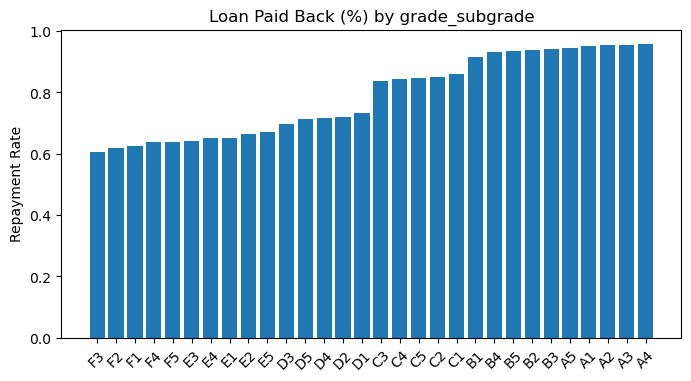

In [13]:
rate = train.groupby('grade_subgrade')['loan_paid_back'].mean().sort_values()

plt.figure(figsize=(8,4))
plt.bar(rate.index, rate.values)
plt.xticks(rotation=45)
plt.ylabel("Repayment Rate")
plt.title("Loan Paid Back (%) by grade_subgrade")
plt.show()

In [14]:
# A1 should be highest score, G5 lowest
grade_map = {'A':6, 'B':5, 'C':4, 'D':3, 'E':2, 'F':1}

def grade_to_score(x):
    letter = x[0]
    number = int(x[1])
    return grade_map[letter] - (number-1)*0.2  # fine-grain penalty for subgrade
X_train['grade_score'] = X_train['grade_subgrade'].apply(grade_to_score)
X_train.drop(columns=['grade_subgrade'], inplace=True)
X_test['grade_score'] = X_test['grade_subgrade'].apply(grade_to_score)
X_test.drop(columns=['grade_subgrade'], inplace=True)

In [15]:
X_train['interest_burden_sq'] = X_train['interest_burden'] ** 2
X_test['interest_burden_sq'] = X_test['interest_burden'] ** 2

X_train['loan_rate_interaction'] = (
    X_train['loan_amount'] * X_train['interest_rate']
)
X_test['loan_rate_interaction'] = (
    X_test['loan_amount'] * X_test['interest_rate']
)

In [16]:
cat_cols = X_train.select_dtypes(include='object').columns.tolist()
num_cols = X_train.select_dtypes(include=['number', 'bool']).columns.tolist()

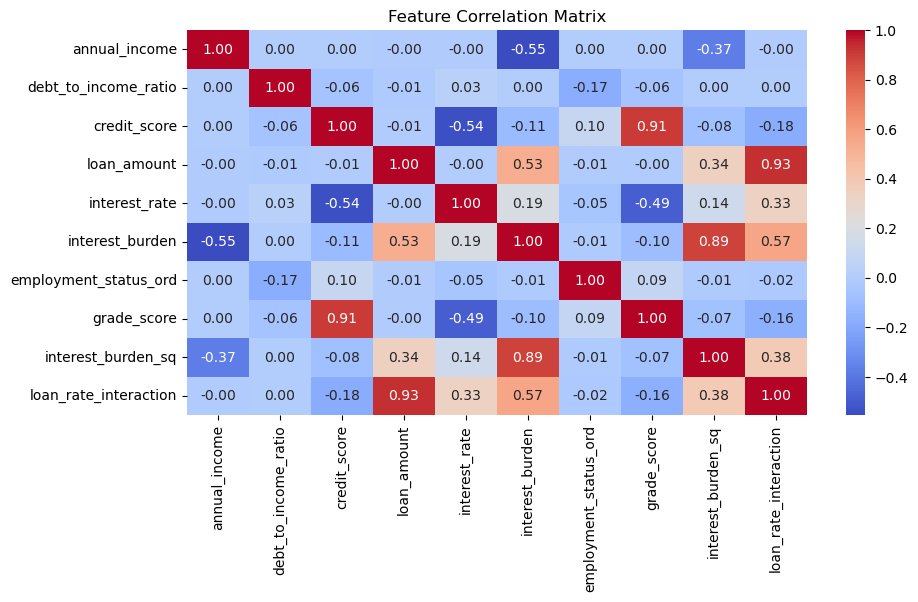

In [17]:
corr_matrix = X_train[num_cols].corr()

plt.figure(figsize=(10, 5))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

In [18]:
from sklearn.base import BaseEstimator, TransformerMixin
# Fixed Feature Engineer
class CreditFeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.credit_bins = None
        self.rate_bins = None
    
    def fit(self, X, y=None):
        # Store bins with explicit edges to handle out-of-range values
        _, self.credit_bins = pd.qcut(X['credit_score'], 10, retbins=True, duplicates='drop')
        _, self.rate_bins = pd.qcut(X['interest_rate'], 10, retbins=True, duplicates='drop')
        
        # Extend edges to handle extreme values in test set
        self.credit_bins[0] = -np.inf
        self.credit_bins[-1] = np.inf
        self.rate_bins[0] = -np.inf
        self.rate_bins[-1] = np.inf
        
        return self
    
    def transform(self, X):
        X = X.copy()
        
        # Interaction features
        X['credit_rate_mul'] = X['credit_score'] * X['interest_rate']
        X['credit_rate_div'] = X['credit_score'] / (X['interest_rate'] + 1e-6)
        X['credit_sq'] = X['credit_score'] ** 2
        X['rate_sq'] = X['interest_rate'] ** 2
        
        # Binned features (as numeric, not categorical)
        X['credit_bin'] = pd.cut(X['credit_score'], bins=self.credit_bins, 
                                  labels=False, include_lowest=True)
        X['rate_bin'] = pd.cut(X['interest_rate'], bins=self.rate_bins, 
                               labels=False, include_lowest=True)
        
        return X

In [19]:
def create_preprocessing_pipeline(cat_cols, num_cols):
    """
    Creates a properly configured preprocessing pipeline
    """
    # Create feature engineering pipeline that operates on full dataframe
    feature_eng_pipeline = Pipeline([
        ('engineer', CreditFeatureEngineer())
    ])
    
    engineered_features = [
        'credit_rate_mul', 'credit_rate_div', 'credit_sq', 
        'rate_sq', 'credit_bin', 'rate_bin'
    ]
    
    # All numeric features (original + engineered)
    all_num_features = num_cols + engineered_features
    
    
    
    # Complete preprocessing
    preprocessor = ColumnTransformer([
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), 
         cat_cols),
        ('num', StandardScaler(), all_num_features)
    ], remainder='drop')
    
    # Combine feature engineering + preprocessing
    full_pipeline = Pipeline([
        ('feature_eng', feature_eng_pipeline),
        ('preprocess', preprocessor)
    ])
    
    return full_pipeline

In [20]:
preprocess = create_preprocessing_pipeline(cat_cols, num_cols)

In [21]:
# rf_pipe = Pipeline([
#     ('pre', preprocess),
#     ('rf', RandomForestClassifier(
#         random_state=42,
#         n_estimators=500,
#         min_samples_split=12,
#         min_samples_leaf=6,
#         max_features=None,
#         bootstrap=True,
#         n_jobs=-1 
#     ))
# ])


# rf_grid = {
#     'rf__n_estimators': [501,651],
#     'rf__max_depth': [15,20],
#     'rf__min_samples_split': [10,15],
#     'rf__min_samples_leaf': [7, 5],
#     'rf__max_features': ['sqrt', None],
#     'rf__bootstrap': [True]
# }


In [102]:
# # Random Forest
# rf_search = RandomizedSearchCV(
#     estimator=rf_pipe,
#     param_distributions=rf_grid,
#     n_iter=25,                    # Will test 30 random combinations
#     cv=3,                         # 3-fold cross-validation
#     scoring='roc_auc',            
#     n_jobs=-1,                    # Use all CPU cores
#     random_state=42,
#     verbose=2,                    # Shows progress
#     return_train_score=True
# )


# print("Training Random Forest...")
# rf_search.fit(X_train, y_train)
# best_rf = rf_search.best_estimator_

# print("RANDOM FOREST RESULTS")
# print(f"Best params: {rf_search.best_params_}")
# print(f"Best CV score: {rf_search.best_score_:.4f}")
# joblib.dump(best_rf,"random_forest_model.pkl")

In [142]:
# XGBoost
xgb_pipe = Pipeline([
    ('pre', preprocess),
    ('xgb', XGBClassifier(tree_method='hist',objective='binary:logistic',eval_metric='auc',random_state=42))
])

xgb_grid = {
    'xgb__n_estimators': np.arange(300, 1001, 150),
    'xgb__max_depth': [5,7,9,11],               
    'xgb__learning_rate': [0.05,0.03,0.1],         
    'xgb__subsample': [0.8, 1],                   
    'xgb__colsample_bytree': [0.7,0.9,1],       
    'xgb__min_child_weight': [1,5,8],           
    'xgb__gamma': [0,0.1,0.3,1],
    'xgb__reg_alpha': [0, 0.1]
}

xgb_search = RandomizedSearchCV(
    estimator=xgb_pipe,
    param_distributions=xgb_grid,
    n_iter=30,                    # More iterations for larger grid
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42,
    verbose=2,
    return_train_score=True
)

print("\nTraining XGBoost...")
xgb_search.fit(X_train, y_train)
best_xgb = xgb_search.best_estimator_

print("XGBOOST RESULTS")
print(f"Best params: {xgb_search.best_params_}")
print(f"Best CV score: {xgb_search.best_score_:.4f}")


Training XGBoost...
Fitting 3 folds for each of 30 candidates, totalling 90 fits
XGBOOST RESULTS
Best params: {'xgb__subsample': 1, 'xgb__reg_alpha': 0, 'xgb__n_estimators': np.int64(450), 'xgb__min_child_weight': 5, 'xgb__max_depth': 5, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0, 'xgb__colsample_bytree': 0.9}
Best CV score: 0.9208


In [ ]:
lgbm_pipe = Pipeline([
    ('pre', preprocess),
    ('lgbm', LGBMClassifier(
        objective='binary',
        metric='auc',
        random_state=42,
        verbose=-1
    ))
])

# Fine-tune around your best parameters
lgbm_grid = {
    "lgbm__n_estimators": [1300, 1400, 1500, 1600],  # Around 1400
    "lgbm__learning_rate": [0.08, 0.09, 0.1, 0.11, 0.12],  # Around 0.1
    "lgbm__max_depth": [3, 4, 5],  # Around 3
    "lgbm__num_leaves": [25, 28, 31, 35, 40],  # Around 31
    "lgbm__min_child_samples": [18, 19, 20, 21, 22],  # Around 20
    "lgbm__subsample": [0.75, 0.78, 0.8, 0.82, 0.85],  # Around 0.8
    "lgbm__colsample_bytree": [0.75, 0.78, 0.8, 0.82, 0.85],  # Around 0.8
    "lgbm__class_weight": ["balanced"],  # Keep balanced
    "lgbm__reg_alpha": [0, 0.01, 0.05, 0.1],  # Add regularization
    "lgbm__reg_lambda": [0, 0.01, 0.05, 0.1],  # Add regularization
}

lgbm_search = RandomizedSearchCV(
    estimator=lgbm_pipe,
    param_distributions=lgbm_grid,
    n_iter=50, 
    cv=5,  # Increased for more stable validation
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42,
    verbose=2,
    return_train_score=True
)

print("Fine-tuning LGBM...")
lgbm_search.fit(X_train, y_train)

print(f"\nBest parameters: {lgbm_search.best_params_}")
print(f"Best CV ROC-AUC: {lgbm_search.best_score_:.5f}")

best_lgbm = lgbm_search.best_estimator_

Fine-tuning LGBM...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best parameters: {'lgbm__subsample': 0.75, 'lgbm__reg_lambda': 0.1, 'lgbm__reg_alpha': 0.1, 'lgbm__num_leaves': 28, 'lgbm__n_estimators': 1500, 'lgbm__min_child_samples': 22, 'lgbm__max_depth': 3, 'lgbm__learning_rate': 0.12, 'lgbm__colsample_bytree': 0.75, 'lgbm__class_weight': 'balanced'}
Best CV ROC-AUC: 0.92275


In [38]:
joblib.dump(best_lgbm, "best_lgbm_model.pkl")

['best_lgbm_model.pkl']

In [ ]:
from catboost import CatBoostClassifier

catboost_pipe = Pipeline([
    ('pre', preprocess),
    ('catboost', CatBoostClassifier(
        n_estimators=1450, learning_rate=0.3, depth=4,
        l2_leaf_reg=3, min_child_samples=10, subsample=1.0,
        colsample_bylevel=0.8, auto_class_weights='Balanced',
        random_state=42, verbose=False
    ))
])
catboost_pipe.fit(X_train, y_train)


lgbm_probs = best_lgbm.predict_proba(X_test)[:, 1]
catboost_probs = catboost_pipe.predict_proba(X_test)[:, 1]

c:\Users\amrit\anaconda3\envs\DSML\lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
c:\Users\amrit\anaconda3\envs\DSML\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\amrit\anaconda3\envs\DSML\lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [56]:
best_catboost = catboost_pipe 

C:\Users\amrit\AppData\Local\Temp\ipykernel_10700\160552282.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=imp_df.head(top), ax=ax, palette='viridis')
C:\Users\amrit\AppData\Local\Temp\ipykernel_10700\160552282.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=imp_df.head(top), ax=ax, palette='viridis')


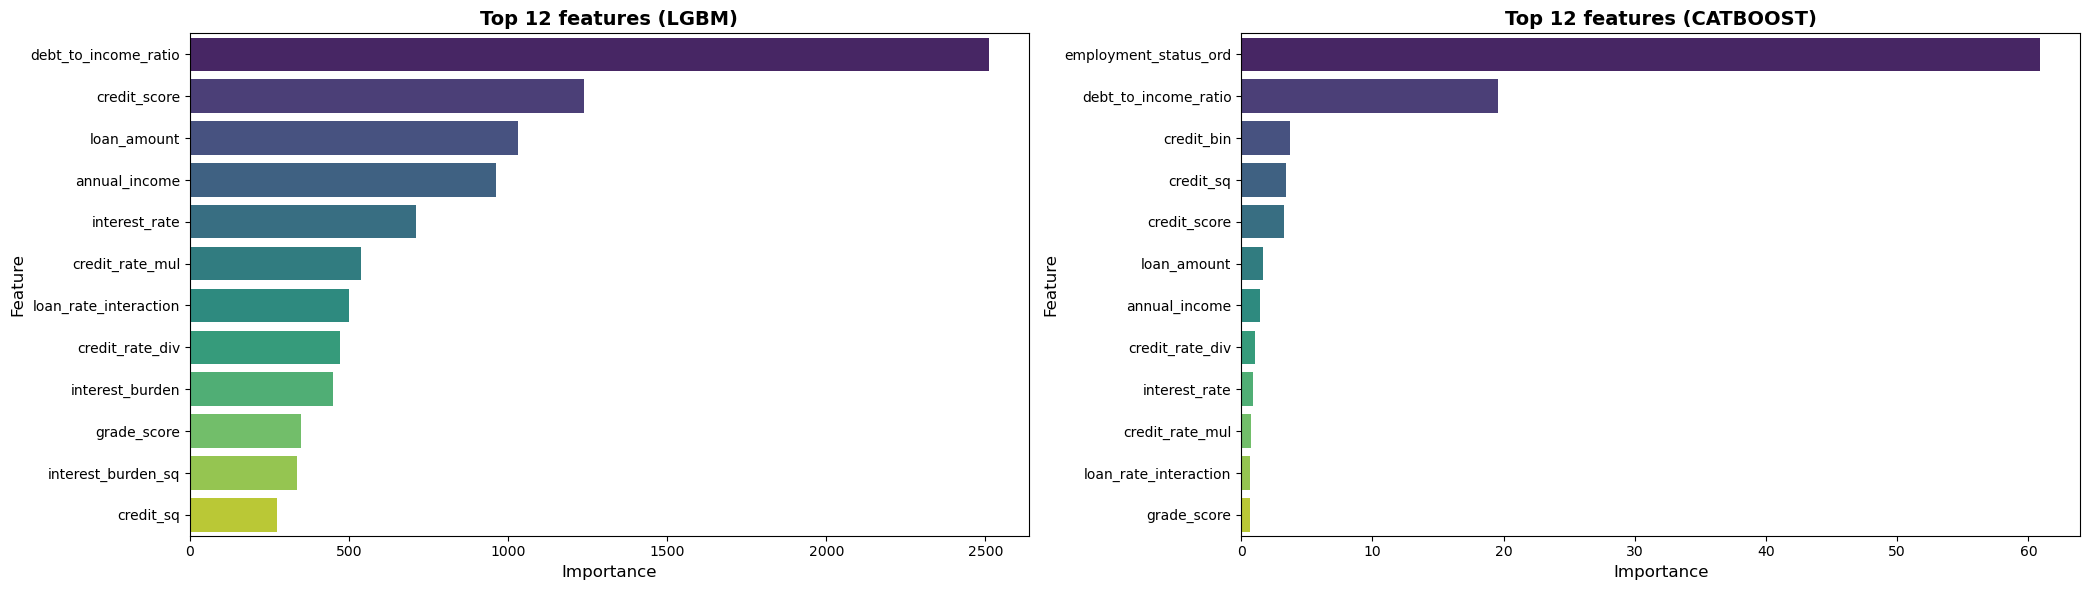

In [ ]:
def plot_importance(pipe, kind, ax, top=12):
    if kind == 'xgb':
        model = pipe.named_steps['xgb']
    elif kind == 'lgbm':
        model = pipe.named_steps['lgbm']
    elif kind == 'catboost':
        model = pipe.named_steps['catboost']
    elif kind == 'rf_pipe':
        model = pipe.named_steps['rf_pipe']
    
    pre_pipeline = pipe.named_steps['pre']
    

    preprocessor = pre_pipeline.named_steps['preprocess']
    
    cats = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols)
    
    # Original numeric features
    original_num = num_cols
    
    # Engineered features created by CreditFeatureEngineer
    engineered_features = [
        'credit_rate_mul', 'credit_rate_div', 'credit_sq', 
        'rate_sq', 'credit_bin', 'rate_bin'
    ]
    
    # All numeric features (original + engineered)
    all_num = original_num + engineered_features
    
    # Combine all features in the correct order
    all_feats = np.concatenate([cats, all_num])
    
    # Get feature importances
    imp = model.feature_importances_
    
    # Check if lengths match
    if len(all_feats) != len(imp):
        print(f"Warning: Feature count mismatch! Features: {len(all_feats)}, Importances: {len(imp)}")
        # Use generic names if mismatch
        all_feats = [f'feature_{i}' for i in range(len(imp))]
    
    imp_df = pd.DataFrame({
        'feature': all_feats, 
        'importance': imp
    }).sort_values('importance', ascending=False)
    
    sns.barplot(x='importance', y='feature', data=imp_df.head(top), ax=ax, palette='viridis')
    ax.set_title(f'Top {top} features ({kind.upper()})', fontsize=14, fontweight='bold')
    ax.set_xlabel('Importance', fontsize=12)
    ax.set_ylabel('Feature', fontsize=12)


fig, axes = plt.subplots(1, 2, figsize=(21, 6)) 

# plot_importance(best_xgb, 'xgb', axes[0])
plot_importance(best_lgbm, 'lgbm', axes[0])
plot_importance(best_catboost, 'catboost', axes[1])
plt.tight_layout()
plt.show()

#cross_val_score throws away that trained version and uses only its hyperparameters to re-train inside the cross-validation loop.

In [ ]:
def evaluate_model(model, X, y, name):
    accuracy = cross_val_score(model, X, y, cv=3, scoring='accuracy', n_jobs=-1)
    auc = cross_val_score(model, X, y, cv=3, scoring='roc_auc', n_jobs=-1)
    
    print(f"{name}")
    print(f"  Accuracy: {accuracy.mean():.4f} ± {accuracy.std():.4f}")
    print(f"  ROC-AUC:  {auc.mean():.4f} ± {auc.std():.4f}")

evaluate_model(best_lgbm, X_train, y_train, "LGBM")
# evaluate_model(best_xgb, X_train, y_train, "XGBoost")
evaluate_model(best_catboost, X_train, y_train, "CatBoost")

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score

# out-of-fold predictions on training set
print("Getting OOF predictions...")
lgbm_oof = cross_val_predict(best_lgbm, X_train, y_train, 
                             cv=5, method='predict_proba', n_jobs=-1)[:, 1]
catboost_oof = cross_val_predict(catboost_pipe, X_train, y_train, 
                                 cv=5, method='predict_proba', n_jobs=-1)[:, 1]


Getting OOF predictions...


In [51]:
# Test different weight combinations
print("\nTesting blend weights:")
print("="*50)

best_score = 0
best_weight = 0

for lgbm_weight in np.arange(0.01, 0.99, 0.01):  # Test 40% to 60%
    catboost_weight = 1 - lgbm_weight
    blended = lgbm_weight * lgbm_oof + catboost_weight * catboost_oof
    score = roc_auc_score(y_train, blended)
    
    if score > best_score:
        best_score = score
        best_weight = lgbm_weight
    
    print(f"LGBM: {lgbm_weight:.2f}, CatBoost: {catboost_weight:.2f} → AUC: {score:.5f}")

print("="*50)
print(f"BEST BLEND: LGBM={best_weight:.2f}, CatBoost={1-best_weight:.2f}")
print(f"Best CV AUC: {best_score:.5f}")
print("="*50)

# Apply best weights to test set
lgbm_test = best_lgbm.predict_proba(X_test)[:, 1]
catboost_test = catboost_pipe.predict_proba(X_test)[:, 1]

test_probs = best_weight * lgbm_test + (1 - best_weight) * catboost_test

submission = pd.DataFrame({'id': test_ids, 'probability': test_probs})
submission.to_csv('submission_optimal_blend.csv', index=False)
print(f"\nSaved submission with {best_weight:.2f}/{1-best_weight:.2f} blend")


Testing blend weights:
LGBM: 0.01, CatBoost: 0.99 → AUC: 0.92223
LGBM: 0.02, CatBoost: 0.98 → AUC: 0.92227
LGBM: 0.03, CatBoost: 0.97 → AUC: 0.92231
LGBM: 0.04, CatBoost: 0.96 → AUC: 0.92235
LGBM: 0.05, CatBoost: 0.95 → AUC: 0.92238
LGBM: 0.06, CatBoost: 0.94 → AUC: 0.92242
LGBM: 0.07, CatBoost: 0.93 → AUC: 0.92246
LGBM: 0.08, CatBoost: 0.92 → AUC: 0.92249
LGBM: 0.09, CatBoost: 0.91 → AUC: 0.92253
LGBM: 0.10, CatBoost: 0.90 → AUC: 0.92256
LGBM: 0.11, CatBoost: 0.89 → AUC: 0.92259
LGBM: 0.12, CatBoost: 0.88 → AUC: 0.92262
LGBM: 0.13, CatBoost: 0.87 → AUC: 0.92266
LGBM: 0.14, CatBoost: 0.86 → AUC: 0.92269
LGBM: 0.15, CatBoost: 0.85 → AUC: 0.92272
LGBM: 0.16, CatBoost: 0.84 → AUC: 0.92275
LGBM: 0.17, CatBoost: 0.83 → AUC: 0.92277
LGBM: 0.18, CatBoost: 0.82 → AUC: 0.92280
LGBM: 0.19, CatBoost: 0.81 → AUC: 0.92283
LGBM: 0.20, CatBoost: 0.80 → AUC: 0.92285
LGBM: 0.21, CatBoost: 0.79 → AUC: 0.92288
LGBM: 0.22, CatBoost: 0.78 → AUC: 0.92290
LGBM: 0.23, CatBoost: 0.77 → AUC: 0.92293
LGBM: 0.24

c:\Users\amrit\anaconda3\envs\DSML\lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
c:\Users\amrit\anaconda3\envs\DSML\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\amrit\anaconda3\envs\DSML\lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(



Saved submission with 0.58/0.42 blend


# DIDN'T USE STACKING & Voting Classifier

In [140]:
from sklearn.linear_model import LogisticRegression

stacking = StackingClassifier(
    estimators=[
        ('lgbm', best_lgbm),
        ('catboost', best_catboost)
    ],
    final_estimator=LogisticRegression(penalty='l2',C=1e-3, max_iter=1000),
    stack_method='predict_proba',
    cv=5,
    n_jobs=-1
)
stacking.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('lgbm',
                                Pipeline(steps=[('pre',
                                                 Pipeline(steps=[('feature_eng',
                                                                  Pipeline(steps=[('engineer',
                                                                                   CreditFeatureEngineer())])),
                                                                 ('preprocess',
                                                                  ColumnTransformer(transformers=[('cat',
                                                                                                   OneHotEncoder(drop='first',
                                                                                                                 handle_unknown='ignore',
                                                                                                                 sparse_output=False),
                                                                                                   ['gender',
                                                                                                    'marital_status',
                                                                                                    'education_level',
                                                                                                    'loan_purpose']),
                                                                                                  ('num',
                                                                                                   St...
                                                                                                    'loan_amount',
                                                                                                    'interest_rate',
                                                                                                    'interest_burden',
                                                                                                    'employment_status_ord',
                                                                                                    'grade_score',
                                                                                                    'credit_rate_mul',
                                                                                                    'credit_rate_div',
                                                                                                    'credit_sq',
                                                                                                    'rate_sq',
                                                                                                    'credit_bin',
                                                                                                    'rate_bin'])]))])),
                                                ('catboost',
                                                 <catboost.core.CatBoostClassifier object at 0x00000212120BD8D0>)]))],
                   final_estimator=LogisticRegression(C=0.001, max_iter=1000),
                   n_jobs=-1, stack_method='predict_proba')

In [141]:
evaluate_model(stacking, X_train, y_train, "stacking")

stacking
  Accuracy: 0.9064 ± 0.0001
  ROC-AUC:  0.9228 ± 0.0007


In [137]:
stacking_probs = stacking.predict_proba(X_test)[:, 1]

c:\Users\amrit\anaconda3\envs\DSML\lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
c:\Users\amrit\anaconda3\envs\DSML\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\amrit\anaconda3\envs\DSML\lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [138]:
submission = pd.DataFrame({
    'id': test_ids,
    'probability': stacking_probs
})
submission.to_csv('submission.csv', index=False)